# Simulation of Anti-cancer Drugs in Biological Membranes

<font size="5">Introduction </Monaco>

<p style='text-align: justify;'> 
Cancer is one of the most important health concerns that has no boundary, influences any organ and kills millions of people every year [1-2]. Distinct characteristics of cancer cells such as adaptation to environmental selection forces and resistance to chemo-/radiotherapy are the major causes of frequent failures in cancer treatment [3-6]. 
Despite of extensive research and progress in the field of drug design for cancer therapy, cancer is still a leading causes of death worldwide. To enhance the efficiency of anti-cancer drugs, it is most important to design the effective drugs. In order to design effective anti-cancer drugs based on development of cancer cells, first we should study the details of interactions with anti-cancer drug and the components of membrane. In this work, we use all-atom Molecular Dynamics simulations to investigate the interaction between anti-cancer drugs and different membrane models using umbrella sampling and thermodynamic integration.

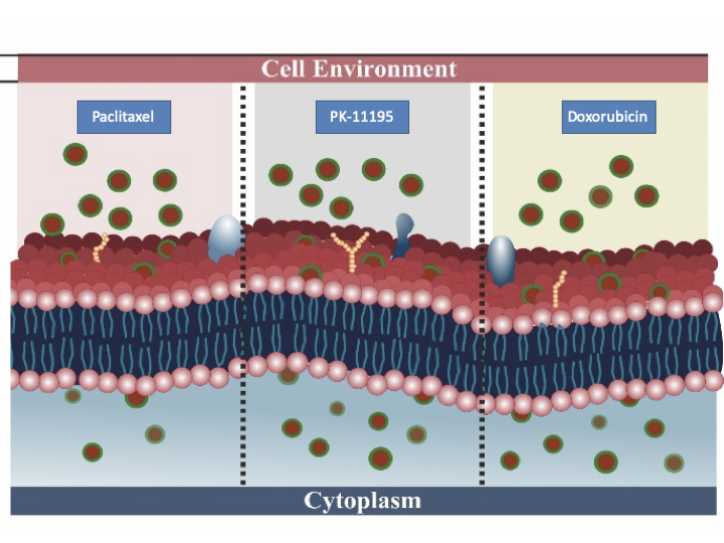

<font size="5">Results </Monaco>

In [16]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os.path, os
from copy import deepcopy
import pandas as pd
import matplotlib.image as mpimg
from copy import deepcopy
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp
from scipy.signal import savgol_filter

In [29]:
#load all data and images
#read images 
imgpcl=mpimg.imread(r'/Users/Najla/Downloads/pcl.png')
imgpk= mpimg.imread(r'/Users/Najla/Downloads/pk.png')
imgdox=mpimg.imread(r'/Users/Najla/Downloads/dox.png')
imgdlpc=mpimg.imread(r'/Users/Najla/Downloads/dlpc.jpg')
imgdppc=mpimg.imread(r'/Users/Najla/Downloads/dppc.jpg')
imgpopc=mpimg.imread(r'/Users/Najla/Downloads/popc.jpg')
figlist=[imgpcl,imgpk,imgdox,imgdlpc,imgdppc,imgpopc]

file=pd.ExcelFile('US-TD.xlsx')

def loadLipid(file, col, sheet):
    return dict(
        topology1 = [pd.read_excel(file, usecols=[col,col+1], names=['r','G'], sheet_name=sheet, header=None).dropna(),
               pd.read_excel(file, usecols=[col+3,col+4], names=['r','G'], sheet_name=sheet, header=None).dropna()],
        topology2 = [pd.read_excel(file, usecols=[col+6,col+7], names=['r','G'], sheet_name=sheet, header=None).dropna(), 
 
                 pd.read_excel(file, usecols=[col+9,col+10], names=['r','G'], sheet_name=sheet, header=None).dropna()])
TDYP1= pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[1], sheet_name='TD').dropna()
TDYP2= pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[2], sheet_name='TD').dropna()
E2= pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[3], sheet_name='TD').dropna()
TDYP6= pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[6], sheet_name='TD').dropna()
E3= pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[7], sheet_name='TD').dropna()
TDYP10= pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[10], sheet_name='TD').dropna()
E4= pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[11], sheet_name='TD').dropna()
t1 = TDYP1.transpose()
t2 = TDYP2.transpose()
t3 = TDYP6.transpose()
t4 = TDYP10.transpose()
e2=E2.T
e3=E3.T
e4=E4.T

yhat1 = savgol_filter(t2, 19, 4)
yhat12 = savgol_filter(t3, 19, 4)
yhat13 = savgol_filter(t4, 19, 4)

yhat = savgol_filter(t2, 19, 4).T
yhat2 = savgol_filter(t3, 19, 4).T
yhat3 = savgol_filter(t4, 19, 4).T


c1=yhat1.flatten()
c2=yhat12.flatten()
c3=yhat13.flatten()

cu1=np.cumsum(c1)
cu2=np.cumsum(c2)
cu3=np.cumsum(c3)
x1=np.array(yhat12-e3).T
x11=np.array(yhat1-e2).T
x111=np.array(yhat13-e4).T
x2=np.array(yhat12+e3).T
x22=np.array(yhat1+e2).T
x222=np.array(yhat13+e4).T
x3=np.array(TDYP1)
x3=x3.flatten()
x1=x1.flatten()
x2=x2.flatten()
x11=x11.flatten()
x22=x22.flatten()
x111=x111.flatten()
x222=x222.flatten()
x1=savgol_filter(x1, 19, 4)
x2=savgol_filter(x2, 19, 4)
x11=savgol_filter(x11, 19, 6)
x22=savgol_filter(x22, 19, 6)
x111=savgol_filter(x111, 19, 6)
x222=savgol_filter(x222, 19, 6)

data = {}
data["Paclitaxel"] = {}
data["Paclitaxel"]["DLPC"] = loadLipid(file, 1, "paclitaxel")
data["Paclitaxel"]["DPPC"] = loadLipid(file, 13, "paclitaxel")
data["Paclitaxel"]["POPC"] = loadLipid(file, 25, "paclitaxel")
data["PK-11195"] = {}
data["PK-11195"]["DLPC"] = loadLipid(file, 1, "pk")
data["PK-11195"]["DPPC"] = loadLipid(file, 13, "pk")
data["PK-11195"]["POPC"] = loadLipid(file, 25, "pk")
data["Doxorubicin"] = {}
data["Doxorubicin"]["DLPC"] = loadLipid(file, 1, "dox")
data["Doxorubicin"]["DPPC"] = loadLipid(file, 13, "dox")
data["Doxorubicin"]["POPC"] = loadLipid(file, 25, "dox")


In [26]:
#functions
#gradient color  
def colorlist(color1, color2, num):
    """Generate list of num colors blending from color1 to color2"""
    result = [np.array(color1), np.array(color2)]
    while len(result) < num:
        temp = [result[0]]
        for i in range(len(result)-1):
            temp.append(np.sqrt((result[i]**2+result[i+1]**2)/2))
            temp.append(result[i+1])
        result = temp
    indices = np.linspace(0, len(result)-1, num).round().astype(int)
    return [result[i] for i in indices]
def interpolate(a1, a2, ax, poly_deg=3, n_points=100, plot=True):
    min_a1_x, max_a1_x = min(a1[:,0]), max(a1[:,0])
    new_a1_x = np.linspace(min_a1_x, max_a1_x, n_points)
    a1_coefs = np.polyfit(a1[:,0],a1[:,1], poly_deg)
    new_a1_y = np.polyval(a1_coefs, new_a1_x)

    min_a2_x, max_a2_x = min(a2[:,0]), max(a2[:,0])
    new_a2_x = np.linspace(min_a2_x, max_a2_x, n_points)
    a2_coefs = np.polyfit(a2[:,0],a2[:,1], poly_deg)
    new_a2_y = np.polyval(a2_coefs, new_a2_x)

    midx = [np.mean([new_a1_x[i], new_a2_x[i]]) for i in range(n_points)]
    midy = [np.mean([new_a1_y[i], new_a2_y[i]]) for i in range(n_points)]
    midxreverse = np.negative(list(reversed(midx)))
    midyreverse = list(reversed(midy))
    midxx=np.append(midx,midxreverse)
    midyy=np.append(midy,midyreverse)

    if plot:
        ax.plot(midxx, midyy, '-', c='black', alpha=2, linewidth=2) 

    return np.array([[x, y] for x, y in zip(midx, midy)])

def plot_umbrella(bx, data, **kwargs):
        alpha=1.0
        offset0 = data[0][(data[0].r<-3.32)].mean().G
        offset1 = data[1][(data[1].r<-3.32)].mean().G
        a = deepcopy(data[0].to_numpy())
        b = deepcopy(data[1].to_numpy())
        a[:,1] = a[:,1] - offset0
        b[:,1] = b[:,1] - offset1

        bx.plot(a[:,0], a[:,1], '--', alpha=alpha, **kwargs)
        bx.plot(b[:,0], b[:,1],'--', alpha=alpha, **kwargs)
        bx.axhline(y=0, color='darkorange', linestyle='--', alpha=1)
        bx.set_xticks([-5, 0])
    
        if (col==1 and row==0):
            bx.set_ylabel('$G(z)$/ $k_{\mathrm{B}}T$')

        if(row==1 and col==2):
            bx.set_xlabel('$Z$/ $\mathrm{nm}$')
       
            
        if(row==0 and col==1):    
            bx.text(2.5, -25.1, r"$\mathrm{w}$", fontsize='x-large', weight='bold', color="deepskyblue",rotation=60)
            bx.text(2.5, -34.1, r"$\mathrm{g}$", fontsize='x-large', weight='bold', color="red",rotation=60);
       
          
        if (col==0 and row==0):
            bx2 = bx.twinx()
            xv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[1], sheet_name='wd-pcl').dropna()
            xw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[4], sheet_name='wd-pcl').dropna()
            yv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[2], sheet_name='wd-pcl').dropna()
            yw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[5], sheet_name='wd-pcl').dropna()
            bx2.plot(xv, yv, '*', alpha=0.2, label=r"$\mathrm{g}$",**kwargs)
            bx2.plot(xw, yw,'--', alpha=alpha,label=r"$\mathrm{w}$",**kwargs)
            bx2.legend(loc=4, fontsize=12,frameon=False)
            for label in bx2.get_yticklabels():
                label.set_color("lightsteelblue")
                bx2.set_yticklabels([])
        
        
        if (col==1 and row==0):
            bx2 = bx.twinx()
            xv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[7], sheet_name='wd-pcl').dropna()
            xw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[10], sheet_name='wd-pcl').dropna()
            yv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[8], sheet_name='wd-pcl').dropna()
            yw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[11], sheet_name='wd-pcl').dropna()
            bx2.plot(xv, yv, '*', alpha=0.2, **kwargs)
            bx2.plot(xw, yw,'--', alpha=alpha, **kwargs)
            for label in bx2.get_yticklabels():
                 label.set_color("skyblue")
                 bx2.set_yticklabels([])
        
        if (col==2 and row==0):
            bx2 = bx.twinx()
            xv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[13], sheet_name='wd-pcl').dropna()
            xw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[16], sheet_name='wd-pcl').dropna()
            yv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[14], sheet_name='wd-pcl').dropna()
            yw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[17], sheet_name='wd-pcl').dropna()
            bx2.plot(xv, yv, '*', alpha=0.2, **kwargs)
            bx2.plot(xw, yw,'--', alpha=alpha, **kwargs)
            for label in bx2.get_yticklabels():
                 label.set_color("skyblue")
                 bx2.set_yticklabels([])
                    
                    
        if (col==0 and row==1):
            bx2 = bx.twinx()
            xv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[1], sheet_name='wd-pk').dropna()
            xw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[4], sheet_name='wd-pk').dropna()
            yv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[2], sheet_name='wd-pk').dropna()
            yw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[5], sheet_name='wd-pk').dropna()
            bx2.plot(xv, yv, '*', alpha=0.2, **kwargs)
            bx2.plot(xw, yw,'--', alpha=alpha, **kwargs)
            for label in bx2.get_yticklabels():
                 label.set_color("skyblue")
                 bx2.set_yticklabels([])
        
        
        if (col==1 and row==1):
            bx2 = bx.twinx()
            xv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[7], sheet_name='wd-pk').dropna()
            xw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[10], sheet_name='wd-pk').dropna()
            yv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[8], sheet_name='wd-pk').dropna()
            yw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[11], sheet_name='wd-pk').dropna()
            bx2.plot(xv, yv, '*', alpha=0.2, **kwargs)
            bx2.plot(xw, yw,'--', alpha=alpha, **kwargs)
            for label in bx2.get_yticklabels():
                 label.set_color("skyblue")
                 bx2.set_yticklabels([])
        
        if (col==2 and row==1):
            bx2 = bx.twinx()
            xv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[13], sheet_name='wd-pk').dropna()
            xw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[16], sheet_name='wd-pk').dropna()
            yv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[14], sheet_name='wd-pk').dropna()
            yw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[17], sheet_name='wd-pk').dropna()
            bx2.plot(xv, yv, '*', alpha=0.2, **kwargs)
            bx2.plot(xw, yw,'--', alpha=alpha, **kwargs)
            for label in bx2.get_yticklabels():
                 label.set_color("skyblue") 
                 bx2.set_yticklabels([])
        
        if (col==0 and row==2):
            bx2 = bx.twinx()
            xv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[1], sheet_name='wd-dox').dropna()
            xw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[4], sheet_name='wd-dox').dropna()
            yv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[2], sheet_name='wd-dox').dropna()
            yw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[5], sheet_name='wd-dox').dropna()
            bx2.plot(xv, yv, '*', alpha=0.2, **kwargs)
            bx2.plot(xw, yw,'--', alpha=alpha, **kwargs)
            bx2.set_yticks([0, 1])
            for label in bx2.get_yticklabels():
                 label.set_color("steelblue")
                 #bx2.set_yticklabels([])
        
        
        if (col==1 and row==2):
            bx2 = bx.twinx()
            xv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[7], sheet_name='wd-dox').dropna()
            xw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[10], sheet_name='wd-dox').dropna()
            yv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[8], sheet_name='wd-dox').dropna()
            yw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[11], sheet_name='wd-dox').dropna()
            bx2.plot(xv, yv, '*', alpha=0.2, **kwargs)
            bx2.plot(xw, yw,'--', alpha=alpha, **kwargs)
            bx2.set_yticks([0, 1])
            for label in bx2.get_yticklabels():
                 label.set_color("steelblue")
            bx2.set_ylabel('$Water\ density$/$\ \mathrm{g/cm^3}$',family='Tahoma')
        
        if (col==2 and row==2):
            bx2 = bx.twinx()
            xv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[13], sheet_name='wd-dox').dropna()
            xw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[16], sheet_name='wd-dox').dropna()
            yv=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[14], sheet_name='wd-dox').dropna()
            yw=pd.read_excel(r'/Users/Najla/Downloads/US-TD.xlsx',usecols=[17], sheet_name='wd-dox').dropna()
            bx2.plot(xv, yv, '*', alpha=0.2, **kwargs)
            bx2.plot(xw, yw,'--', alpha=alpha, **kwargs)
            bx2.set_yticks([0, 1])
            for label in bx2.get_yticklabels():
                 label.set_color("steelblue") 
        
        interpolate(a, b, bx, 10, plot=True)

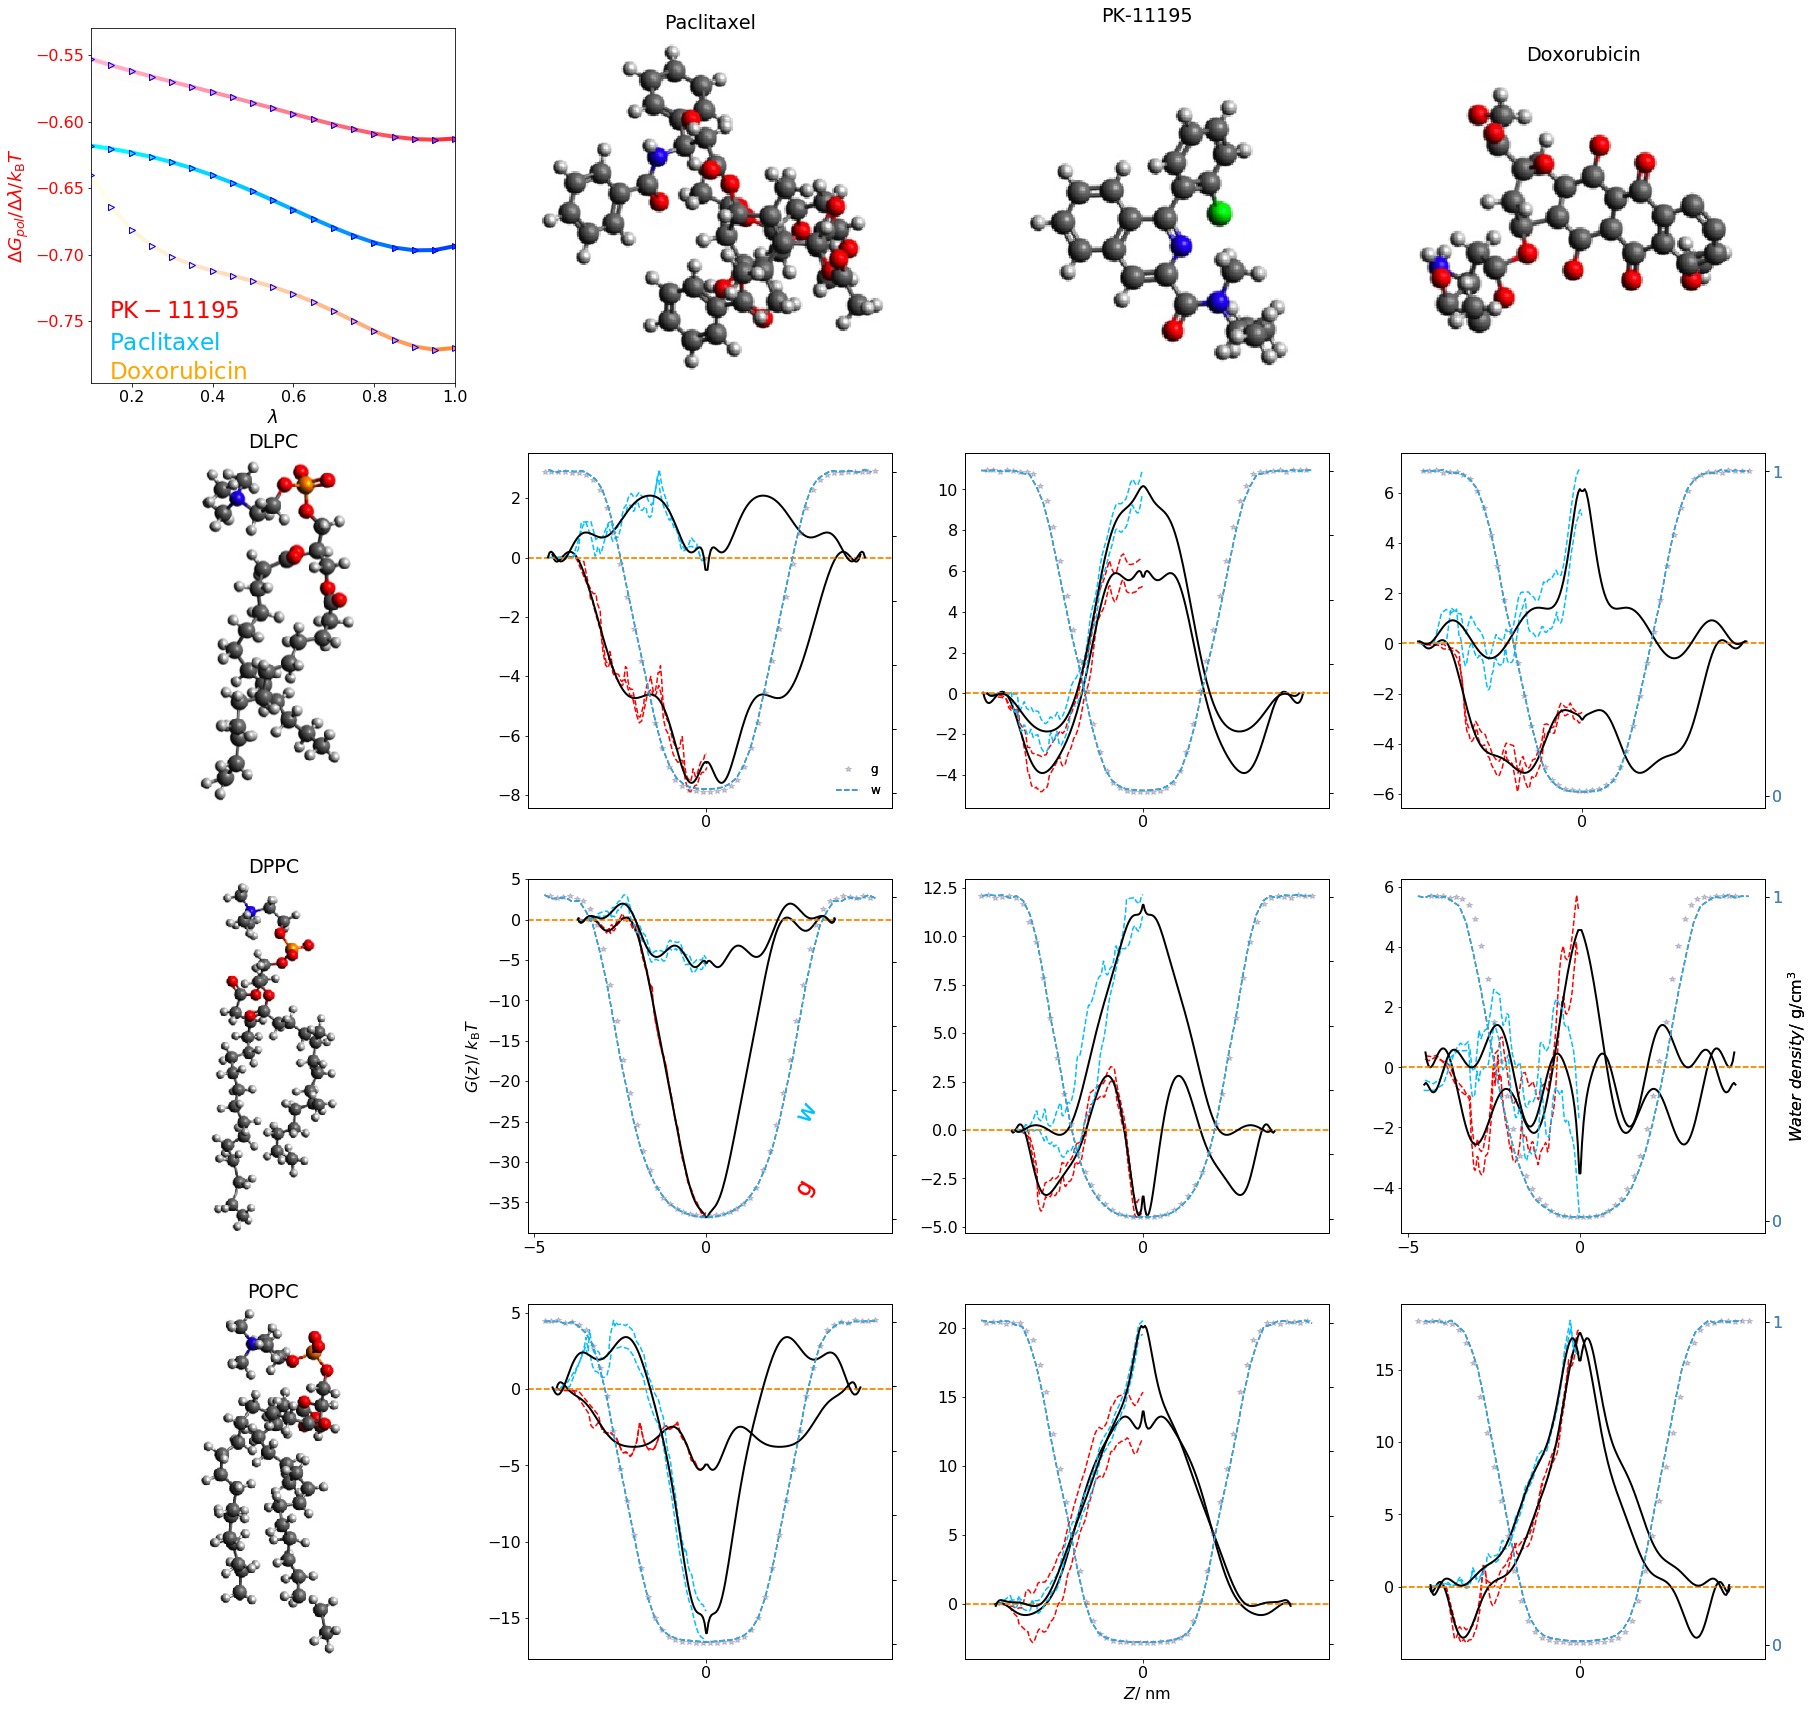

In [30]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': [30, 30]})
fig, ax = plt.subplots(4, 4)

ax[0,0].set_xlim([0.1, 1])

colors1 = colorlist((1, 0.7, 0.8), (1, 0, 0), len(TDYP1))

for i in range(len(TDYP1)-1):
    xi = TDYP1[i:i+1+1]
    yi = yhat2[i:i+1+1]
    ci = colors1[i]
    xi=xi/20
    x3=x3/20
    ax[0,0].plot(xi, yi, color=ci, label=r"$\mathrm{PK-11195}$",linewidth=4.00,marker='>',markeredgecolor="blue") 
    ax[0,0].fill_between(x3,x2, x1,alpha=0.01,color="red")

colors2 = colorlist((0, 1, 1), (0, 0, 1), len(TDYP1))

for i in range(len(TDYP1)-1):
    xi = TDYP1[i:i+1+1]
    yi = yhat[i:i+1+1]
    ci = colors2[i]
    xi=xi/20
    x3=x3/20
    ax[0,0].plot(xi, yi, color=ci,label=r"$\mathrm{Paclitaxel}$",linewidth=4.00,marker='>',markeredgecolor="blue") 
    ax[0,0].fill_between(x3,x22, x11, alpha=0.01,color="#1155dd")


colors3 = colorlist((1, 1, 0.9), (1, 0.5, 0), len(TDYP1))

for i in range(len(TDYP1)-1):
    xi = TDYP1[i:i+1+1]
    yi = yhat3[i:i+1+1]
    ci = colors3[i]
    xi=xi/20
    x3=x3/20
    ax[0,0].plot(xi, yi, color=ci, label=r"$\mathrm{Doxorubicin}$",linewidth=4.00, marker='>',markeredgecolor="blue")  
    ax[0,0].fill_between(x3,x222, x111,alpha=0.01,color="orange")


ax[0,0].set_xlabel(r'$\lambda$', fontsize=18)
ax[0,0].set_ylabel(r'$\Delta G _{pol}/\Delta\lambda/k_{\mathrm{B}}T$ ', fontsize=18, color="red")
for label in ax[0,0].get_yticklabels():
    label.set_color("red")
ax[0,0].text(0.05, 0.2,r"$\mathrm{PK-11195}$", fontsize='x-large',horizontalalignment='left', weight='bold', color="red",verticalalignment='center', transform=ax[0,0].transAxes)
ax[0,0].text(0.05, 0.11, r"$\mathrm{Paclitaxel}$", fontsize='x-large',horizontalalignment='left', weight='bold', color="deepskyblue",verticalalignment='center', transform=ax[0,0].transAxes)
ax[0,0].text(0.05, 0.03, r"$\mathrm{Doxorubicin}$", fontsize='x-large',horizontalalignment='left', weight='bold', color="orange",verticalalignment='center', transform=ax[0,0].transAxes)    
    
for i in range(3):
    ax[0, i+1].axis('off')
    ax[i+1, 0].axis('off')

j=0
k=3
row=0
for drugname, lipiddata in data.items():
    col =0
    
    for lipidname, val in lipiddata.items():
        if col==0:
            ax[col,row+1].set_title(drugname, fontsize='large')           
            ax[col,row+1].imshow(figlist[j])
            j+=1
           
        if row==0:
            ax[col+1,row].set_title(lipidname, fontsize='large')
            ax[col+1,row].imshow(figlist[k])
            k+=1
            
        plot_umbrella(ax[col+1,row+1], val["topology1"], color='red')
        plot_umbrella(ax[col+1,row+1], val["topology2"], color='deepskyblue')
        col = col + 1
    row = row + 1



plt.savefig('umbrella.pdf', bbox_inches='tight', dpi=300)

<font size="5">References </Monaco>

(1) Fidler, I. J. The pathogenesis of cancer metastasis: the'seed and soil'hypothesis revisited. Nature reviews cancer 2003, 3 (6), 453.


(2) Bray, F.; Ferlay, J.; Soerjomataram, I.; Siegel, R. L.; Torre, L. A.; Jemal, A. Global cancer statistics 2018: GLOBOCAN estimates of incidence and mortality worldwide for 36 cancers in 185 countries. CA: a cancer journal for clinicians 2018, 68 (6), 394-424.


(3) Holohan, C.; Van Schaeybroeck, S.; Longley, D. B.; Johnston, P. G. Cancer drug resistance: an evolving paradigm. Nature Reviews Cancer 2013, 13 (10), 714.


(4) Morin, P. J. Drug resistance and the microenvironment: nature and nurture. Drug Resistance Updates 2003, 6 (4), 169-172.


(5) Coley, H. M. Mechanisms and strategies to overcome chemotherapy resistance in metastatic breast cancer. Cancer treatment reviews 2008, 34 (4), 378-390.


(6) Barker, H. E.; Paget, J. T.; Khan, A. A.; Harrington, K. J. The tumour microenvironment after radiotherapy: mechanisms of resistance and recurrence. Nature reviews Cancer 2015, 15 (7), 409.